# Finding Patterns in Data
## LSI and Scikit-Learn
    Samuel Goldrup
    MATH 403
    11 October 2022

In [1]:
import os
import string
import numpy as np
from math import log
from scipy import sparse
from sklearn import datasets
from scipy import linalg as la
from collections import Counter
import matplotlib
matplotlib.use('nbAgg')
from matplotlib import pyplot as plt
from scipy.sparse import linalg as spla
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Problem 1
- Perform PCA on the breast cancer dataset
- Graph the first two principal components
- Calculate the variance captured by the first two principal components

In [2]:
def prob1():
    """Recreate the plot in Figure 1 by performing PCA on the breast 
    cancer dataset. Translate the columns of X to have mean 0.
    Include the amount of variance captured by the first two principal 
    components in the graph title."""
    cancer = datasets.load_breast_cancer() 
    X = cancer.data
    y = cancer.target #load in the data!!
    miu = X.mean(axis=0) #mean and variance 
    var = X.var(axis=0)
    X -= miu
    #X /= var
    Y = X
    u,s,vh = np.linalg.svd(X,full_matrices=False)
    #get the variance captured
    var_captured = sum([sing**2 for sing in s[:2]]) / sum([sing**2 for sing in s])
    V = vh.T
    print(Y.shape,V[:,:2].shape)
    Y_hat = Y@V[:,:2]
    idx_malignant = np.where(y==1)[0]
    idx_benign = np.where(y==0)[0]
    #scatter plot the two tranches
    plt.scatter(Y_hat[idx_malignant,0],Y_hat[idx_malignant,1],label="malignant",alpha=0.5)
    plt.scatter(Y_hat[idx_benign,0],Y_hat[idx_benign,1],label="benign",alpha=0.5)
    plt.xlabel("First Principal Component")
    plt.ylabel("Second Principal Component")
    plt.title(f"Breast Cancer PCA ({var_captured*100}% of variance)")
    
    plt.legend()
    plt.show()

(569, 30) (30, 2)


<IPython.core.display.Javascript object>


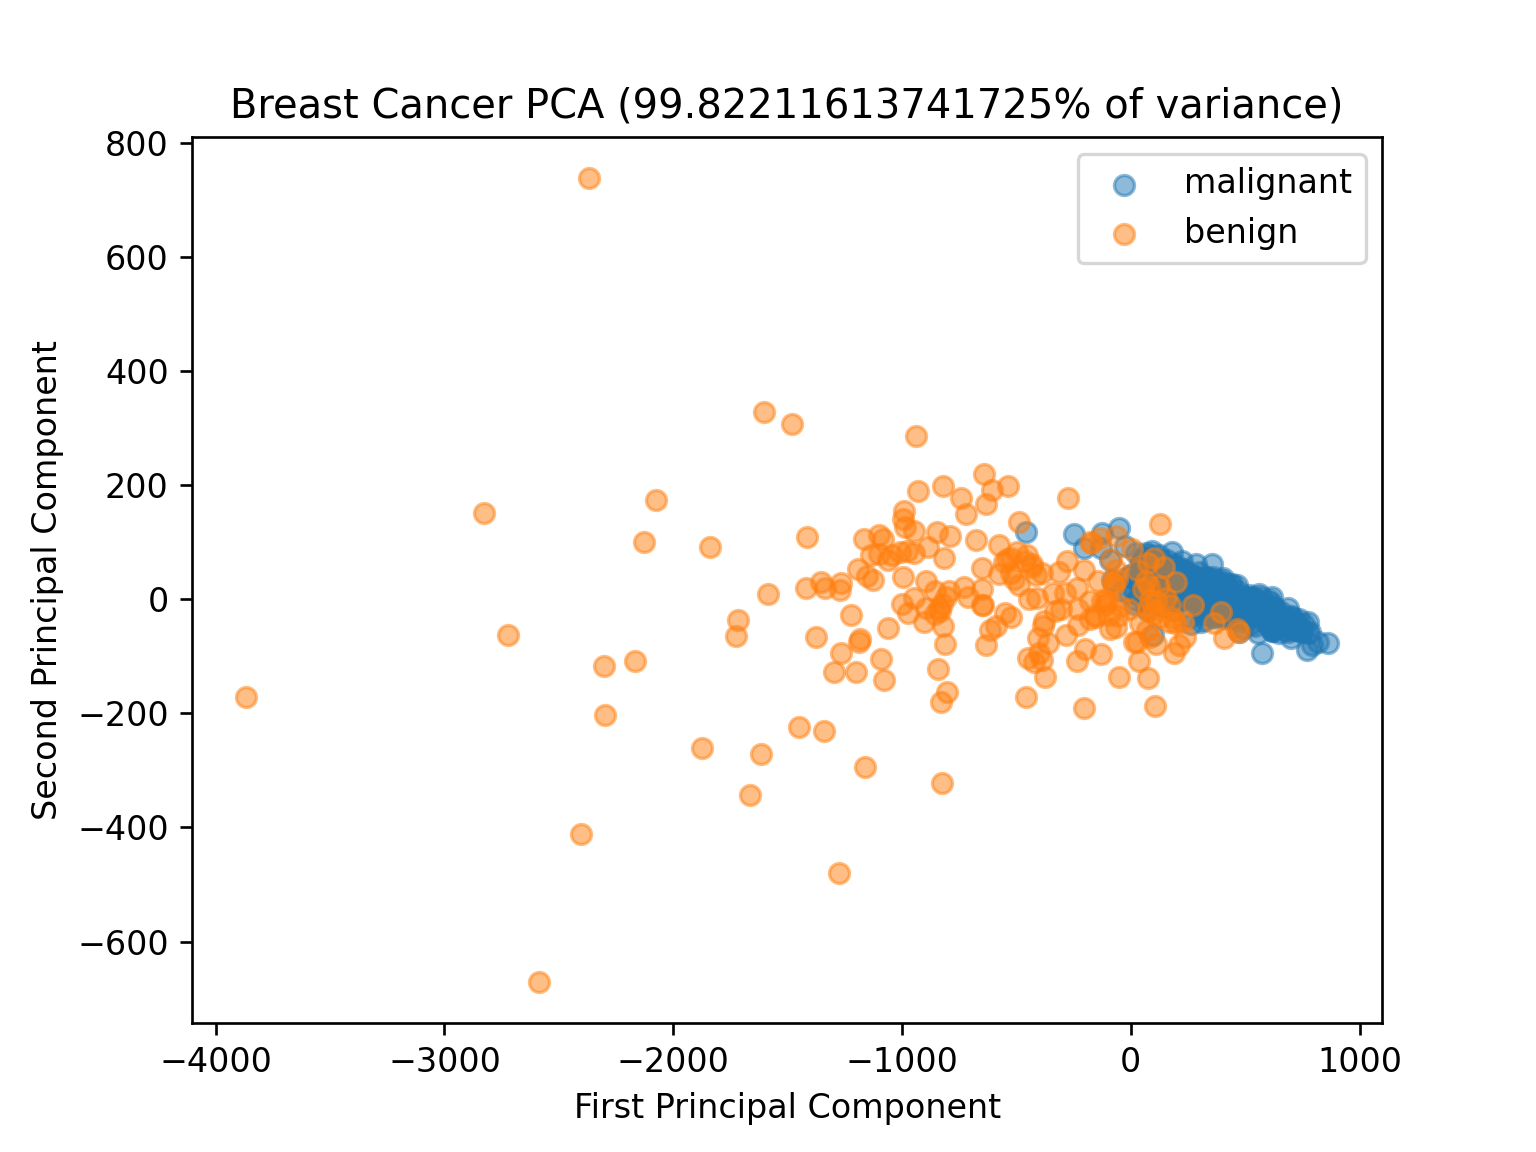

In [3]:
prob1()

## Problem 2
Implement the function similar()

In [4]:
def similar(i, Xhat):
    """
    Takes an index and matrix representing the principal components 
    of a document and returns two indices: the index of the document 
    that is least similar and the index of the document that is most 
    similar to i.
    
    Parameters:
        i: index of a document
        Xhat: decomposed data
    
    Returns:
        index_min: index of the document least similar to document i
        index_max: index of the document most similar to document i
    """
    #matrix of cosine similarities
    cosine_sims = np.array([[np.dot(Xhat[i],Xhat[j])/(np.linalg.norm(Xhat[i])*np.linalg.norm(Xhat[j])) for i in range(len(Xhat))] for j in range(len(Xhat))])
    np.fill_diagonal(cosine_sims,np.nan) #ignore if i==j
    minner = np.nanargmin(cosine_sims[i])
    maxxer = np.nanargmax(cosine_sims[i])
    return minner, maxxer

    #sims = np.dot(np.delete(Xhat,i))

### Function for Problem 3

In [5]:
def document_converter():
    """
    Converts speech documents into an n by m array where m is the number 
    of vocabulary words and n is the number of documents.
    
    Returns:
        X ((n x m) sparse matrix): Each row represents a document
        paths (list): list where each element is a speech path 
            eg: path[0] is './Addresses/1990-Bush.txt'
    """
    # Get list of filepaths to each text file in the folder.
    folder = "./Addresses/"
    paths = [folder+p for p in os.listdir(folder) if p.endswith(".txt")]

    # Helper function to get list of words in a string.
    def extractWords(text):
        ignore = string.punctuation + string.digits
        cleaned = "".join([t for t in text.strip() if t not in ignore])
        return cleaned.lower().split()

    # Initialize vocab set, then read each file and add to the vocab set.
    vocab = set()
    for p in paths:
        with open(p, 'r', encoding="utf8") as infile:
            for line in infile:
                vocab.update(extractWords(line)) # Union sets together

    # Load stopwords
    with open("stopwords.txt", 'r',  encoding="utf8") as f:
        stops = set([w.strip().lower() for w in f.readlines()])

    # Remove stopwords from vocabulary, create ordering
    vocab = {w:i for i, w in enumerate(vocab.difference(stops))}


    counts = []      # holds the entries of X
    doc_index = []   # holds the row index of X
    word_index = []  # holds the column index of X

    # Iterate through the documents.
    for doc, p in enumerate(paths):
        with open(p, 'r', encoding="utf8") as f:
            # Create the word counter.
            ctr = Counter()
            for line in f:
                ctr.update(extractWords(line))
            # Iterate through the word counter, storing counts.
            for word, count in ctr.items():
                if word in vocab:
                    word_index.append(vocab[word])
                    counts.append(count)
                    doc_index.append(doc)

    # Create sparse matrix holding these word counts.
    X = sparse.csr_matrix((counts, [doc_index, word_index]),
                           shape=(len(paths), len(vocab)), dtype=float)
    return X, paths

## Problem 3
Use the function above and PCA to find speeches most and least similar to a given speech.

In [6]:
def prob3(speech, l=7):
    """
    Uses LSI, applied to the word count matrix X, with the first 7 
    principal components to find the most similar and least similar 
    speeches.

    Parameters:
        speech (str): Path to speech eg: "./Addresses/1984-Reagan.txt"
        l (int): Number of principal components

    Returns:
        tuple of str: (Most similar speech, least similar speech)
    """
    X,paths = document_converter()
    i = paths.index(speech)
    U,s,Vh = spla.svds(X,k=l) #sparse svd
    V = Vh.T
    Xhat = X@V[:,:l] #PCA math
    idxmin,idxmax = similar(i,Xhat)
    least,most = paths[idxmin].split('/')[-1][:-4], paths[idxmax].split('/')[-1][:-4]
    return most,least

In [7]:
# Run this box once you have written prob3()
speech = './Addresses/1984-Reagan.txt'
print(prob3(speech))

speech = "./Addresses/1993-Clinton.txt"
print(prob3(speech))

('1988-Reagan', '1946-Truman')
('2010-Obama', '1951-Truman')


## Problem 4
Edit the end of the following function to return a weighted sparse matrix A.

In [8]:
def weighted_document_converter():
    """
    Converts speech documents into an n by m array where m is the number 
    of vocabulary words and n is the number of documents. It gives weights
    to the most important words in the vocabulary.
    
    Returns:
        A ((n x m) sparse matrix): Each row represents a document
        paths (list): list where each element is a speech path 
            eg: path[0] is './Addresses/1990-Bush.txt'
    """
    # Get list of filepaths to each text file in the folder.
    folder = "./Addresses/"
    paths = [folder+p for p in os.listdir(folder) if p.endswith(".txt")]

    # Helper function to get list of words in a string.
    def extractWords(text):
        ignore = string.punctuation + string.digits
        cleaned = "".join([t for t in text.strip() if t not in ignore])
        return cleaned.lower().split()

    # Initialize vocab set, then read each file and add to the vocab set.
    vocab = set()
    for p in paths:
        with open(p, 'r', encoding="utf8") as infile:
            for line in infile:
                vocab.update(extractWords(line)) # Union sets together

    # Load stopwords
    with open("stopwords.txt", 'r',  encoding="utf8") as f:
        stops = set([w.strip().lower() for w in f.readlines()])

    # Remove stopwords from vocabulary, create ordering
    vocab = {w:i for i, w in enumerate(vocab.difference(stops))}

    t = np.zeros(len(vocab)) # holds global count for each word
    counts = []      # holds the entries of X
    doc_index = []   # holds the row index of X
    word_index = []  # holds the column index of X

    # Get doc-term counts and global term counts
    for doc, p in enumerate(paths):
        with open(p, 'r', encoding="utf8") as f:
            # Create the word counter.
            ctr = Counter()
            for line in f:
                words = extractWords(line)
                ctr.update(words)
            # Iterate through the word counter, storing counts
            for word, count in ctr.items():
                if word in vocab:
                    word_ind = vocab[word]
                    word_index.append(word_ind)
                    counts.append(count)
                    doc_index.append(doc)
                    t[word_ind] += count
        
    #problem 4
    X, _ = document_converter()    
    # Get global weights
    P = X / X.sum(axis=1)
    g = 1 + (1/np.log(len(paths)))*((np.multiply(P,np.log(1+P))).sum(axis=1))
    A = np.multiply(g,np.log(X.todense()+1))
    
    return sparse.csr_matrix(A), paths

In [9]:
weighted_document_converter()

(<66x13905 sparse matrix of type '<class 'numpy.float64'>'
 	with 78023 stored elements in Compressed Sparse Row format>,
 ['./Addresses/1945-Truman.txt',
  './Addresses/1946-Truman.txt',
  './Addresses/1947-Truman.txt',
  './Addresses/1948-Truman.txt',
  './Addresses/1949-Truman.txt',
  './Addresses/1950-Truman.txt',
  './Addresses/1951-Truman.txt',
  './Addresses/1953-Eisenhower.txt',
  './Addresses/1955-Eisenhower.txt',
  './Addresses/1956-Eisenhower.txt',
  './Addresses/1957-Eisenhower.txt',
  './Addresses/1958-Eisenhower.txt',
  './Addresses/1959-Eisenhower.txt',
  './Addresses/1960-Eisenhower.txt',
  './Addresses/1961-Kennedy.txt',
  './Addresses/1962-Kennedy.txt',
  './Addresses/1963-Johnson.txt',
  './Addresses/1963-Kennedy.txt',
  './Addresses/1964-Johnson.txt',
  './Addresses/1965-Johnson-1.txt',
  './Addresses/1965-Johnson-2.txt',
  './Addresses/1966-Johnson.txt',
  './Addresses/1967-Johnson.txt',
  './Addresses/1968-Johnson.txt',
  './Addresses/1969-Johnson.txt',
  './Addre

## Problem 5
Use the weighted_document_converter() function above and scikit-learn's PCA to find speeches most and least similar to a given speech.

In [10]:
def prob5(speech, l=7):
    """
    Uses LSI, applied to the globally weighted word count matrix A, with 
    the first 7 principal components to find the most similar and least 
    similar speeches.

    Parameters:
        speech (str): Path to speech eg: "./Addresses/1984-Reagan.txt"
        l (int): Number of principal components

    Returns:
        tuple of str: (Most similar speech, least similar speech)
    """
    X,paths = weighted_document_converter()
    pca = PCA(n_components=l) #use sklearn's version of PCA instead
    Xhat = pca.fit_transform(X.toarray())
    
    i = paths.index(speech)
    idxmin,idxmax = similar(i,Xhat)
    least,most = paths[idxmin].split('/')[-1][:-4], paths[idxmax].split('/')[-1][:-4]
    return most, least

In [11]:
# Run this box after you have completed prob5()
speech = './Addresses/1984-Reagan.txt'
print(prob5(speech))

speech = "./Addresses/1993-Clinton.txt"
print(prob5(speech))

('1985-Reagan', '1961-Kennedy')
('1994-Clinton', '1951-Truman')


## Problem 6
- Split the breast cancer dataset into training and testing sets using random_state=2
- Fit KNeighborsClassifier and RandomForestClassifier to the training data
- Predict labels for the testing set
- Print a classification_report for each classifier
- Write a few sentences explaining which classifier would be better to use in this situation and why

In [12]:
X,y=datasets.load_breast_cancer()['data'],datasets.load_breast_cancer()['target']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=2)
knn = KNeighborsClassifier(n_neighbors=2) #biuld knn classifier from sklearn
knn.fit(X_train, y_train)
knn_predicted = knn.predict(X_test)
print("KNN: \n", classification_report(y_test, knn_predicted))

rf = RandomForestClassifier() #bulid rf classififer
rf.fit(X_train,y_train)
rf_predicted = rf.predict(X_test)
print("rf \n", classification_report(y_test,rf_predicted))


KNN: 
               precision    recall  f1-score   support

           0       0.85      0.91      0.88        56
           1       0.94      0.90      0.92        87

    accuracy                           0.90       143
   macro avg       0.89      0.90      0.90       143
weighted avg       0.90      0.90      0.90       143

rf 
               precision    recall  f1-score   support

           0       0.94      0.91      0.93        56
           1       0.94      0.97      0.95        87

    accuracy                           0.94       143
   macro avg       0.94      0.94      0.94       143
weighted avg       0.94      0.94      0.94       143



The random forest is better because it has a higher recall (0.95>0.91)

## Problem 7
- Use the breast cancer dataset split from Problem 6
- Run a GridSearch with a RandomForestClassifier, modifying at least three parameters.
- Use scoring="f1"
- Print out best_params_ and best_score_
- Print a confusion matrix for the test data

In [14]:
X,y=datasets.load_breast_cancer()['data'],datasets.load_breast_cancer()['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)   #Split the data into training and testing sets
rf = RandomForestClassifier()  #make rand forest

#parameter space to search over
param_grid = {
    "n_estimators": [20, 40, 60, 80, 100], 
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [5, 10, 15, 20],
}
rf_gs = GridSearchCV(rf, param_grid, scoring='f1', n_jobs=-1)
rf_gs.fit(X_train, y_train) #best fit

print(rf_gs.best_params_, rf_gs.best_score_, sep='\n')

the_best_model = rf_gs.best_estimator_ #this is the best model
prediction = the_best_model.predict(X_test)  
CM = confusion_matrix(y_test, prediction) #confusion matrix from page 29
display(CM)

{'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 40}
0.9761375844550504


c:\miniconda\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
100 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "c:\miniconda\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\miniconda\lib\site-packages\sklearn\ensemble\_forest.py", line 441, in fit
    trees = Parallel(
  File "c:\miniconda\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\miniconda\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    se

array([[51,  5],
       [ 4, 83]], dtype=int64)

## Problem 8
- Create a pipeline with a StandardScaler, PCA, and a KNeighborsClassifier
- Do a grid search, modifying at least 6 parameters
- Print your best parameters and best score (f1)
- Get a score of at least .96

In [15]:
X,y=datasets.load_breast_cancer()['data'],datasets.load_breast_cancer()['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

#initialize the pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()), ("pca", PCA()), ("classifier", KNeighborsClassifier())])
#hyperparameter space to search over
pipe_param_grid = {
    "scaler__with_mean": [True, False],
    "scaler__with_std": [True, False],    
    "pca__n_components": [2,3,4,5],
    "pca__svd_solver": ['auto', 'full', 'arpack', 'randomized'],
    "classifier__weights": ["uniform", "distance"],
    "classifier__algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
}
#fit using the model with the best hyperparameters
pipe_gs = GridSearchCV(pipe, pipe_param_grid, n_jobs=-1).fit(X_train, y_train)
print(pipe_gs.best_params_, pipe_gs.best_score_, sep='\n')

{'classifier__algorithm': 'auto', 'classifier__weights': 'uniform', 'pca__n_components': 5, 'pca__svd_solver': 'auto', 'scaler__with_mean': True, 'scaler__with_std': True}
0.9601094391244871
